In [ ]:
# Build geo library and polygons to display in Carto

In [2]:
# Install libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pickle
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from pathlib import Path
path = Path(r'/Users/_DMT/jupyter/covid')



In [3]:
#state flip
#FYI in the county level data, DC is ia 

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

#flip the other way
us_state_flip = {v:k for k,v in us_state_abbrev.items()}

#get the polygon lat/longs by us county

rf = requests.get(r'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
fips_dict = rf.json()

In [4]:
#pull geometric shapes of counties
#Get the geometric points of the counties, scrubbing those that have extra set of [] on list
geo_dict = {d['properties']['STATE'] + d['properties']['COUNTY']:{d['geometry']['type']:d['geometry']['coordinates']} 
            if len(d['geometry']['coordinates']) > 1 else {d['geometry']['type']:d['geometry']['coordinates'][0]} for d in fips_dict['features']}

#get the fips codes with a multipolygon
mp = []
for k, v in geo_dict.items():
    if v.get('Polygon', None) == None:
        mp.append(k)
    
    #If it says polygon but the first entry is >2, must be a multi
    elif len(v['Polygon'][0]) > 2:
        geo_dict[k] = {'MultiPolygon':geo_dict[k]['Polygon']}
        mp.append(k)
    

#remove the extra [] from 2nd level of multipolygons
for i in mp:
    for c, l in enumerate(geo_dict[i]['MultiPolygon']):
        if len(l) == 1:
            geo_dict[i]['MultiPolygon'][c] = l[0]
            
#County name change in SD
geo_dict['46102'] = geo_dict['46113']

#Is a multi, says poly


In [5]:
#test to see if there are double brack lists with lat/longs
flag = []
for k, v in geo_dict.items():
    if v.get('Polygon', None) == None:
        if len(v['MultiPolygon']) == 1:
            flag.append(k)
            print("here")

        else:
            for i in v['MultiPolygon']:
                if len(i) == 1:
                    flag.append(k)
                    print("here")
    else:
        if len(v['Polygon']) == 1:
            flag.append(k)
            print("here")
if not flag:
    print('Lat longs imported correctly')

Lat longs imported correctly


In [6]:
# function to turn counties into polygons or multipolygons
def county_geo(gd):
    poly = []
    fips = [k for k in gd.keys()]
    for k in fips:
        try:
            if gd[k].get('Polygon') != None:
                poly.append(Polygon(gd[k].get('Polygon')))
            else:
                poly.append(MultiPolygon([Polygon(p) for p in geo_dict[k]['MultiPolygon']]))
        except:
            print(k)
            break
            
    return dict(zip(fips, poly))



In [7]:
poly_dict = county_geo(geo_dict)

In [8]:
# Pull unemployment data to test geopandas
col_types = {'Location': 'str', 'Date': 'str', 'Labor force': 'int', 'Employed': 'int',
            'Unemployed': 'int', 'Unemlpoyment rate': 'float', 'fips': 'str',
            'County': 'str', 'State': 'str'}

df_geo = pd.read_csv(path/'county_unemployment.csv', index_col=[0], dtype=col_types)

df_geo.head()

,Location,Date,Labor force,Employed,Unemployed,Unemployment rate,fips,County,State
25752,"Autauga County, AL",2020-01-01,25912,25125,787,3.0,01001,Autauga,Alabama
25753,"Baldwin County, AL",2020-01-01,95316,92389,2927,3.1,01003,Baldwin,Alabama
25754,"Barbour County, AL",2020-01-01,8509,8186,323,3.8,01005,Barbour,Alabama
25755,"Bibb County, AL",2020-01-01,8629,8342,287,3.3,01007,Bibb,Alabama
25756,"Blount County, AL",2020-01-01,25098,24352,746,3.0,01009,Blount,Alabama


In [9]:

df_geo['geometry'] = df_geo['fips'].apply(lambda x: poly_dict.get(x))

df_geo.sample(5)


,Location,Date,Labor force,Employed,Unemployed,Unemployment rate,fips,County,State,geometry
36232,"Fremont County, IA",2020-04-01,3565,3359,206,5.8,19071,Fremont,Iowa,"POLYGON ((-95.76564500000001 40.585208, -95.75..."
31749,"Cache County, UT",2020-02-01,65067,63587,1480,2.3,49005,Cache,Utah,"POLYGON ((-111.885476 41.426435, -111.916568 4..."
41147,"White County, TN",2020-05-01,12385,11104,1281,10.3,47185,White,Tennessee,"POLYGON ((-85.60287599999999 35.794996, -85.60..."
40474,"Greene County, NY",2020-05-01,20772,18504,2268,10.9,36039,Greene,New York,"POLYGON ((-74.451713 42.169225, -74.5373100000..."
28049,"Snyder County, PA",2020-01-01,19877,18661,1216,6.1,42109,Snyder,Pennsylvania,"POLYGON ((-76.800242 40.881994, -76.798714 40...."


In [10]:
df = df_geo.loc[:, ['County', 'State', 'fips',]]
df.loc[:, 'Loc'] = df['County'] + ', ' + df['State']
df.drop_duplicates(subset=['Loc'], inplace=True)



In [14]:
df_fips.head()

,fips,geometry,County,State,Loc,Centroid
0,01001,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",Autauga,Alabama,"Autauga, Alabama",POINT (-86.64120 32.53615)
1,01009,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",Blount,Alabama,"Blount, Alabama",POINT (-86.56976 33.98525)
2,01017,"POLYGON ((-85.18413 32.87053, -85.12342 32.772...",Chambers,Alabama,"Chambers, Alabama",POINT (-85.38992 32.91159)
3,01021,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",Chilton,Alabama,"Chilton, Alabama",POINT (-86.71979 32.85025)
4,01033,"POLYGON ((-88.13999 34.58170, -88.13925 34.587...",Colbert,Alabama,"Colbert, Alabama",POINT (-87.80589 34.70164)


In [11]:
#create the fips to geo mapping
df_fips = pd.DataFrame({'fips':[k for k in poly_dict.keys()]})
df_fips['geometry'] = df_fips['fips'].apply(lambda x: poly_dict[x])
df_fips = pd.merge(df_fips, df, how='left', on='fips')
df_fips = gpd.GeoDataFrame(df_fips, geometry='geometry')
df_fips['Centroid'] = df_fips.centroid
df_fips.to_csv(path/'fips_and_counties.csv')

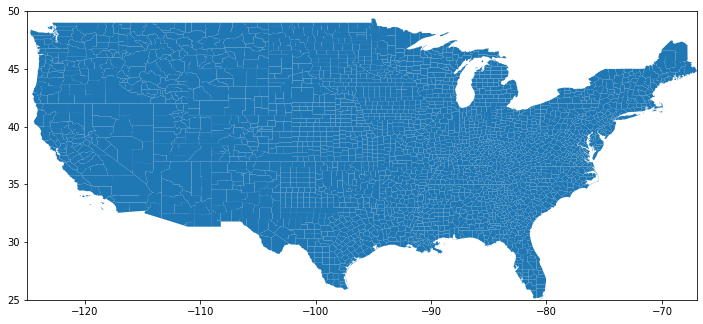

In [13]:

fig, ax = plt.subplots(1, figsize=(12, 12))
ax = df_fips.plot(ax=ax)
plt.xlim(-125, -67)
plt.ylim(25, 50)
plt.show()

In [20]:
df_geo = gpd.GeoDataFrame(df_geo)


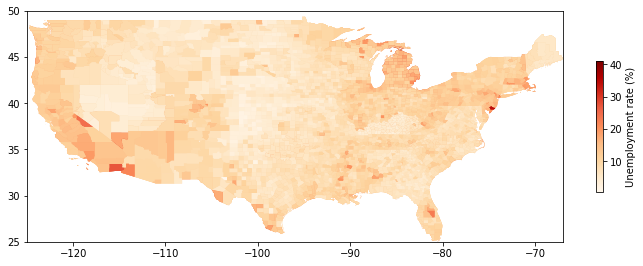

In [36]:


fig, ax = plt.subplots(1, figsize=(12, 12))

ax = df_geo.plot(ax=ax, column='Unemployment rate', legend=True,
                legend_kwds={'label': 'Unemployment rate (%)',
                             'orientation': 'vertical',
                             'shrink': .2}, 
                 cmap='OrRd')
plt.xlim(-125, -67)
plt.ylim(25, 50)

plt.show()

In [ ]:
# Apple mobility data

apple_url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev42/v2/en-us/applemobilitytrends-2020-04-28.csv'


apple = pd.read_csv(apple_url)
apple.drop(['alternative_name'], axis=1, inplace=True)
apple.sample(5)

r'''
#csv url changes by day, attempts to automate fetch failed
driver = webdriver.Chrome(executable_path="C:/Users/40732/chromedriver.exe")
driver.get('https://www.apple.com/covid19/mobility')
#driver.find_element_by_class_name('download-button-container').text


xpath = '/html/body/div[1]/div/ui-main-pane/div[2]/div[3]/div[2]'

xpath = '//a[@href="'+'https://covid19-static.cdn-apple.com/covid19-mobility-data/'+'"]'
#out = driver.find_element_by_xpath(xpath).get_attribute('outerHTML')
out = driver.find_element_by_class_name('download-button-container').get_attribute('outerHTML')

driver.close()
apple_url = out[out.find('https'):out.find('.csv')+4]
out
'''
''


### Mobility trends


list_keep = ['New York City', 'Baltimore', 'Boston', 'San Francisco - Bay Area', 'Chicago', 'Dallas', 'Seattle', 'Houston', 'Detroit', 'Miami', 'Atlanta',
             'United States', 'Washington DC', 'Denver', 'Philadelphia']

apple.drop(apple[~apple['region'].isin(list_keep)].index, axis=0, inplace=True)

for c in apple.columns[4:]:
    apple.loc[:, c] = pd.to_numeric(apple.loc[:, c])

new_apple = apple.melt(id_vars = ['geo_type', 'region', 'transportation_type'], var_name='Date', value_name='Score').drop(
    'geo_type', axis=1).pivot_table(index=['region', 'Date'], columns = 'transportation_type').reset_index()

new_apple.columns = ['City', 'Date', 'Driving', 'Transit', 'Walking']

new_apple['State'] = new_apple['City'].apply(lambda x: us_state_flip.get(dict_city[x].strip()))
new_apple['Latitude'] = new_apple['City'].apply(lambda x: ll_dict[x][0])
new_apple['Longitude'] = new_apple['City'].apply(lambda x: ll_dict[x][1])

new_apple.loc[new_apple['City'] == 'San Francisco - Bay Area', 'City'] = 'San Francisco'
new_apple.to_csv(path/'Apple_mobility.csv')

new_apple.sample(5)

